In [428]:
import os
import sys
import h5py
import pickle
import subprocess
import numpy as np
from time import time
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from sklearn.preprocessing import MinMaxScaler

import keras
import keras.backend as K
from keras.layers import Input, LSTM, BatchNormalization
from keras.models import Model, load_model

In [2]:
sys.path.append('..')

In [3]:
from modis_utils.misc import cache_data, restore_data

In [4]:
data = restore_data(os.path.join('cache', 'boundary_vectors_ALL_1.dat'))

In [5]:
for x in data:
    print(x.shape)

(598, 1657, 2)
(92, 1657, 2)


In [6]:
train_boundary_vectors = data[0]
test_boundary_vectors = data[1]

In [7]:
train_boundary_vectors.shape, test_boundary_vectors.shape

((598, 1657, 2), (92, 1657, 2))

In [8]:
n_points = train_boundary_vectors.shape[1]

In [9]:
n_years = len(train_boundary_vectors)//46
n_years

13

In [10]:
data_train = train_boundary_vectors[:0].copy()
data_test = test_boundary_vectors
for i in range(n_years):
    year = 2003 + i
    if year != 2011 and year != 2013:
        data_train = np.vstack([data_train, train_boundary_vectors[i*46 : (i + 1)*46]])
print(data_train.shape)

(506, 1657, 2)


In [13]:
data_train_1 = data_train.reshape(data_train.shape[0], -1)
data_train_1.shape

(506, 3314)

In [15]:
data_test_1 = data_test.reshape(data_test.shape[0], -1)

In [16]:
variants = []

In [17]:
for i in range(data_train_1.shape[0]):
    var = np.var(data_train_1[:, i])
    variants.append((var, i))

In [20]:
variants_1 = variants.copy()

In [21]:
variants_2 = np.asarray(variants_1)
variants_2

array([[0.00000000e+00, 0.00000000e+00],
       [1.59444805e+01, 1.00000000e+00],
       [0.00000000e+00, 2.00000000e+00],
       ...,
       [7.57799684e-01, 5.03000000e+02],
       [2.17207736e-01, 5.04000000e+02],
       [1.55218797e+00, 5.05000000e+02]])

In [22]:
np.where(variants_2[:,0] > 2)

(array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
         27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
         53,  55,  57,  59,  61,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  73,  75,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97, 157, 159,
        161, 163, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
        177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
        203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
        216, 217, 218, 219, 229, 239, 241, 242, 243, 244, 245, 246, 247,
        248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
        261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
        274, 275, 276, 277, 278, 279, 281, 282, 283, 285, 286, 287, 288,
        289, 290, 291, 303, 305, 306, 307, 308, 309

In [23]:
list_idx = np.where(variants_2[:, 0] > 1)[0]

In [41]:
len(list_idx)

345

In [43]:
data_train_2 = data_train_1[:, list_idx]
data_train_2.shape

(506, 345)

In [42]:
data_test_2 = data_test_1[:, list_idx]
data_test_2.shape

(92, 345)

In [46]:
scaler = MinMaxScaler()
scaler.fit(data_train_2)

/home/anhkhoa/anaconda3/envs/pytf/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [47]:
data_train_3 = scaler.transform(data_train_2)
data_test_3 = scaler.transform(data_test_2)

In [52]:
def create_sequence_data(data_train, data_test, timesteps=12):
    data_all = np.vstack([data_train, data_test])
    len_val = 46
    len_train = len(data_train) - timesteps - len_val
    len_test = len(data_test)
    
    train_X = []
    train_y = []
    val_X = []
    val_y = []
    test_X = []
    test_y = []
    
    for i in range(timesteps, timesteps + len_train):
        X = np.expand_dims(data_all[i - timesteps : i], axis=0)
        y = np.expand_dims(data_all[i], axis=0)
        train_X.append(X)
        train_y.append(y)
        
    for i in range(timesteps + len_train, timesteps + len_train + len_val):
        X = np.expand_dims(data_all[i - timesteps : i], axis=0)
        y = np.expand_dims(data_all[i], axis=0)
        val_X.append(X)
        val_y.append(y)
        
    for i in range(timesteps + len_train + len_val, timesteps + len_train + len_val + len_test):
        X = np.expand_dims(data_all[i - timesteps : i], axis=0)
        y = np.expand_dims(data_all[i], axis=0)
        test_X.append(X)
        test_y.append(y)
        
    return np.vstack(train_X), np.vstack(train_y), np.vstack(val_X), np.vstack(val_y), np.vstack(test_X), np.vstack(test_y)

In [53]:
train_X, train_y, val_X, val_y, test_X, test_y = create_sequence_data(data_train_3, data_test_3)

In [54]:
data = {}
data['train_X'] = train_X
data['train_y'] = train_y
data['val_X'] = val_X
data['val_y'] = val_y
data['test_X'] = test_X
data['test_y'] = test_y

In [55]:
for k, v in data.items():
    print(v.min(), v.max())

0.0 1.0000000000000009
0.0 1.0000000000000009
0.0 1.0000000000000009
0.0 1.0000000000000009
0.0 1.0000000000000009
0.0 1.0000000000000009


In [25]:
def save_data_pickle(data, path):
    with open(path, 'wb') as f:
        pickle.dump(data, f)

def load_data_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def create_empty_list(n):
    res = []
    for _ in range(n):
        res.append(None)
    return res

def mse(x, y):
    return np.mean((x - y)**2)

In [217]:
class LSTM_1:

    def __init__(self, data, data_train_full, list_idx=None, scaler=None, mode='train'):
        self.model_dir = 'lstm'
        self.model_path = os.path.join(self.model_dir, 'lstm.h5')
        self.mode = mode
        self.model = None
        
        self.data = data
        
        self.units = data['train_X'].shape[2]
        self.timesteps = data['train_X'].shape[1]
        self.full_shape = data_train_full.shape[-1]
        
        if list_idx is None:
            self.list_idx = np.arange(self.full_shape)
        self.list_idx = list_idx

        if not os.path.exists(self.model_dir):
            os.makedirs(self.model_dir)
            
        if self.mode == 'inference':
            self.model = self.load_model(self.model_dir)
            
        self.list_small_variant_idx = np.setdiff1d(np.arange(self.full_shape), self.list_idx)
        self.default_values = {}
        for i in self.list_small_variant_idx:
            mean_value = np.mean(data_train_full[:, i])
            self.default_values[i] = int(mean_value)
            
        self.scaler = scaler
        

    def load_model(self, model_dir=None):
        if model_dir is None:
            model_dir = self.model_dir
        model_path = os.path.join(model_dir, 'lstm.h5')
        return load_model(model_path)
    
    def _create_model(self):
        input_shape = (self.timesteps, self.units)
        inputs = Input(input_shape)
        x = LSTM(self.units*2, return_sequences=True)(inputs)
        x = LSTM(self.units)(x)
        model = Model(inputs=inputs, outputs=x)
        model.compile(loss='mse', optimizer='adam')
        return model
    
    def train(self, epochs=1, batch_size=1):
        K.clear_session()
        self.model = self._create_model()
        history = self.model.fit(self.data['train_X'], self.data['train_y'],
                                 epochs=epochs, batch_size=batch_size,
                                 validation_data=(data['val_X'], data['val_y']))
        plt.plot(history.history['loss'], color='r', label='train loss')
        plt.plot(history.history['val_loss'], color='b', label='val loss')
        plt.legend()
        self.model.save(self.model_path)
        return self.model_path
        
    def inference(self, input_test, return_full=None, return_original_range=False):
        if self.model is None:
            self.model = self.load_model()
        if len(input_test.shape) == 2:
            input_test = np.expand_dims(input_test, axis=0)
        inferences = self.model.predict(input_test, batch_size=64)
        if return_full:
            inferences = self.scaler.inverse_transform(inferences)
            outputs = []
            for idx, input_test_i in enumerate(input_test):
                predictions = inferences[idx]
                res = create_empty_list(self.full_shape)
                for i, prediction in zip(self.list_idx, predictions):
                    res[i] = prediction
                for i, default_value in self.default_values.items():
                    res[i] = default_value
                outputs.append(np.asarray(res))
            outputs = np.asarray(outputs)
            return outputs
        if return_original_range:
            inferences = self.scaler.inverse_transform(inferences)
        return inferences

    def eval(self, inputs=None, groundtruths=None, return_original_range=False):
        if inputs is None:
            inputs = self.data['test_X']
        if groundtruths is None:
            groundtruths = self.data['test_y']
        groundtruth_shape = groundtruths.shape[-1]
        return_full = (groundtruth_shape == self.full_shape)
        predictions = self.inference(inputs, return_full, return_original_range)
        if return_original_range:
            groundtruths = self.scaler.inverse_transform(groundtruths)
        
        loss = (groundtruths - predictions)**2
        return loss, predictions

Train on 448 samples, validate on 46 samples
Epoch 1/20
448/448 [==============================] - 2s 5ms/step - loss: 0.1404 - val_loss: 0.0747
Epoch 2/20
448/448 [==============================] - 0s 899us/step - loss: 0.0750 - val_loss: 0.0532
Epoch 3/20
448/448 [==============================] - 0s 898us/step - loss: 0.0634 - val_loss: 0.0436
Epoch 4/20
448/448 [==============================] - 0s 883us/step - loss: 0.0548 - val_loss: 0.0375
Epoch 5/20
448/448 [==============================] - 0s 850us/step - loss: 0.0514 - val_loss: 0.0365
Epoch 6/20
448/448 [==============================] - 0s 881us/step - loss: 0.0499 - val_loss: 0.0364
Epoch 7/20
448/448 [==============================] - 0s 901us/step - loss: 0.0491 - val_loss: 0.0372
Epoch 8/20
448/448 [==============================] - 0s 906us/step - loss: 0.0483 - val_loss: 0.0343
Epoch 9/20
448/448 [==============================] - 0s 877us/step - loss: 0.0473 - val_loss: 0.0340
Epoch 10/20
448/448 [==================

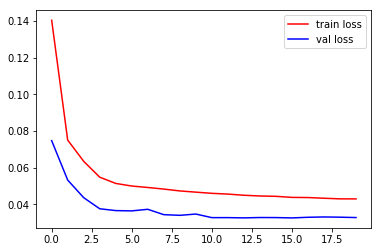

In [108]:
lstm_1 = LSTM_1(data, data_train_1, list_idx, scaler, mode='train')
model_path = lstm_1.train(epochs=20, batch_size=64)

In [152]:
lstm_1 = LSTM_1(data, data_train_1, list_idx, scaler, mode='inference')
losses, predictions = lstm_1.eval(return_original_range=True)
print(losses)
print(losses.mean())

[[1.58968952e+01 1.94145012e+01 2.83872900e+01 ... 3.44462385e+03
  1.19460016e+01 1.05589297e+01]
 [8.66192728e+00 1.79969316e+01 1.60943770e+01 ... 4.61927241e+02
  3.14897433e-01 5.26209269e-01]
 [8.30058162e+00 1.02576639e+01 1.51407626e+01 ... 3.58818476e+03
  1.95378676e-01 1.63340069e+00]
 ...
 [4.22324575e-02 1.97922889e-01 4.74944128e+00 ... 1.17229126e+02
  1.26370312e+00 2.90226572e-01]
 [2.82615796e-03 8.49567363e-02 1.15040812e+00 ... 1.45171318e+02
  1.28727749e+00 3.11175213e-01]
 [8.00513778e-01 7.43937836e-01 2.67571304e-03 ... 1.47017105e+02
  1.45618782e+00 2.64392049e-01]]
40.897616972849356


In [134]:
inference_dir = 'inference'
if not os.path.exists(inference_dir):
    os.makedir(inference_dir)
cache_data(predictions, os.path.join(inference_dir, 'lstm.dat'))

In [135]:
inputs = lstm_1.data['test_X'][:1]
groundtruths = lstm_1.data['test_y'][:1]
inputs.shape, groundtruths.shape

((1, 12, 345), (1, 345))

In [136]:
predictions.shape

(92, 345)

In [160]:
def get_predictions_multi_steps(lstm_1, n_steps=1):
    inputs = lstm_1.data['test_X'][:1]
    outputs = []
    for i in range(n_steps):
        predict = lstm_1.inference(inputs, return_full=False)
        outputs.append(predict)
        inputs = np.concatenate([inputs[:, 1:, :], np.expand_dims(predict, axis=0)], axis=1)
    return np.asarray(outputs)

In [218]:
lstm_1 = LSTM_1(data, data_train_1, list_idx, scaler, mode='inference')
predictions_multi_steps = get_predictions_multi_steps(lstm_1, 2)

In [422]:
def get_full_shape_predictions_multi_steps(lstm_1, n_steps=1):
    predictions = get_predictions_multi_steps(lstm_1, n_steps)
    predictions = lstm_1.scaler.inverse_transform(predictions.squeeze())
    res = np.zeros((predictions.shape[0], lstm_1.full_shape))
    for i, idx in enumerate(lstm_1.list_idx):
        res[:, idx] = predictions[:, i].astype(np.int)
    for i, default_value in lstm_1.default_values.items():
        res[:, i] = default_value
    return res

In [423]:
full_shape_predictions_multi_steps = get_full_shape_predictions_multi_steps(lstm_1, 80)
print(full_shape_predictions_multi_steps.shape)

(80, 3314)


In [424]:
def reshape_to_point(x):
    return x.reshape(x.shape[0], -1, 2)

In [425]:
full_shape_predictions_multi_steps = reshape_to_point(full_shape_predictions_multi_steps)
full_shape_predictions_multi_steps.shape

(80, 1657, 2)

In [430]:
def convert_boundaries_to_image(boundary, img_width, img_height):
    img = np.zeros((img_width, img_height))
    for i in range(boundary.shape[0]):
        x = boundary[i][0].astype(np.int32)
        y = boundary[i][1].astype(np.int32)
        img[x, y] = 1
    return img

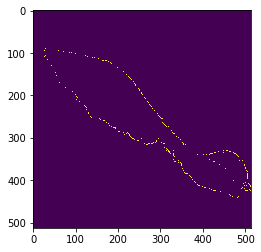

In [431]:
img1 = convert_boundaries_to_image(full_shape_predictions_multi_steps[0], 513, 513)
plt.imshow(img1)

# Calculate Polygon area

In [449]:
full_shape_predictions_multi_steps.shape, data_test.shape

((80, 1657, 2), (92, 1657, 2))

In [451]:
def find_border(data_points):
    x = data_points[:, 0]
    y = data_points[:, 1]
    return x.min(), y.min(), x.max(), y.max()

class Line:
    def __init__(self, x1, y1, x2, y2):
        self.a = y1 - y2
        self.b = x2 - x1
        self.c = x1*y2 - x2*y1
    def calc(self, x, y):
        return self.a*x + self.b*y + self.c
    
def convert_boundary_vector_to_polygon(boundary_vector):
    x1, y1, x2, y2 = find_border(boundary_vector)
    line = Line(x1, y1, x2, y2)
    score_point = [line.calc(x, y) for x, y in boundary_vector]
    group_1 = []
    group_2 = []
    for i, p in enumerate(boundary_vector):
        if score_point[i] < 0:
            group_1.append(p)
        else:
            group_2.append(p)
    group_1 = sorted(group_1, key=itemgetter(0,1))
    group_2 = sorted(group_2, key=itemgetter(0,1), reverse=True)
    group = np.vstack([group_1, group_2])
    return Polygon(zip(group[:, 0], group[:, 1]))

region = [(10, 10), (200, 10), (512, 400), (512, 512), (300, 512), (10, 100), (10, 10)]

def check_point_in_region(p, lines, sample_scores):
    for line, sample_score in zip(lines, sample_scores):
        score = line.calc(p[0], p[1])
        if score/sample_score < 0:
            return False
    return True

def get_points_in_region(boundary, region):
    lines = []
    sample_point = (256, 256)
    for i in range(len(region) - 1):
        lines.append(Line(*(region[i] + region[i + 1])))
    res = []
    sample_scores = [line.calc(sample_point[0], sample_point[1]) for line in lines]
    for p in boundary:
        if check_point_in_region(p, lines, sample_scores):
            res.append(p)
    return np.vstack(res)

def calc_area(points, region):
    points = get_points_in_region(points, region)
    p = convert_boundary_vector_to_polygon(points)
    pp = p.buffer(0)
    return pp.area

In [452]:
print(calc_area(full_shape_predictions_multi_steps[0], region))
print(calc_area(data_test[0], region))

44311.290436174466
44083.31550802139


In [453]:
print(calc_area(full_shape_predictions_multi_steps[1], region))
print(calc_area(data_test[1], region))

44267.290436174466
43810.010416666664


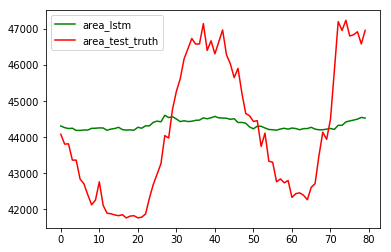

In [454]:
area_lstm = []
for boundary_vector in full_shape_predictions_multi_steps:
    area = calc_area(boundary_vector, region)
    area_lstm.append(area)
    
area_test_truth = []
for boundary_vector in data_test[:80]:
    area = calc_area(boundary_vector, region)
    area_test_truth.append(area)

plt.plot(area_lstm, color='green', label='area_lstm')
plt.plot(area_test_truth, color='r', label='area_test_truth')
plt.legend()